# Implement a basic RAG pipeline with Haystack 2.0

This notebook demonstrates how to implement a basic Retrieval Augmented Generation (RAG) pipeline using the `Haystack` orchestration framework and HuggingFace e.g `SmolLM` LLM Models. You can select your difficulty by trying out different models, knowledge base, tasks, or reimplementing in a different frameworks or even without one.

<div style='background-color: lightblue; padding: 10px; border-radius: 5px; margin-bottom: 20px; color:black'>
    <h2 style='margin: 0;color:blue'>Exercise: </h2>
    <p>Implement a RAG pipeline and tailor it to your needs. </p> 
    <p><b>Difficulty Levels</b></p>
    <p>🐢 Follow step-by-step instructions. Try different embedding and generative model variants.</p>
    <p>🐕 Try different documents and evaluation questions.</p>
    <p>🦁 Reimplement part of or the whole pipeline with different modules or frameworks.</p>
</div>


### Dependencies  
- **`haystack-ai`**: Core framework for building RAG pipelines.  
- **`wikipedia`**: Downloads data from Wikipedia (optional; any document source can be used, such as PDFs, web pages, or local text files).  
- **`sentence_transformers`**: Generates embeddings for document chunks.  
- **`transformers`**: Utilizes open-source LLMs for generation.  
- **`accelerate`** and **`bitsandbytes`**: Enable efficient, low-memory model inference using quantized versions.  


In [ ]:
! pip install wikipedia haystack-ai transformers accelerate bitsandbytes sentence_transformers

In [3]:
import torch
import random
import wikipedia

from haystack import Pipeline
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.preprocessors import DocumentCleaner, DocumentSplitter
from haystack.components.embedders import SentenceTransformersTextEmbedder, SentenceTransformersDocumentEmbedder
from haystack.components.writers import DocumentWriter
from haystack.document_stores.types import DuplicatePolicy
from haystack.utils import ComponentDevice
from haystack.dataclasses import Document

from haystack.components.generators import HuggingFaceLocalGenerator

from huggingface_hub import login
login()

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)

model_llm = "HuggingFaceTB/SmolLM2-135M-Instruct"
model_emb = "sentence-transformers/all-MiniLM-L6-v2"

### Indexing Pipeline (Index Stage)

In the indexing pipeline. We'll download Wikipedia pages using the `wikipedia` library and convert them into `Haystack` Documents. 

In [6]:
raw_docs = []

wiki_pages = [
    "FIFA World Cup", 
    "UEFA Champions League", 
    "Copa América", 
    "CONCACAF Gold Cup", 
    "Africa Cup of Nations", 
    "Copa Libertadores", 
    "European Championship", 
    "Major League Soccer", 
    "Premier League", 
    "La Liga", 
    "Bundesliga", 
    "Serie A", 
    "Ligue 1", 
    "Ballon d'Or"
]

for title in wiki_pages:
    try:
        page = wikipedia.page(title=title, auto_suggest=False)
        doc = Document(content=page.content, meta={"title": page.title, "url": page.url})
        raw_docs.append(doc)
    except wikipedia.exceptions.DisambiguationError as e:
        print(f"Disambiguation error for {title}: {e.options}")
    except wikipedia.exceptions.HTTPTimeoutError:
        print(f"Timeout error while fetching {title}")


In [7]:
questions = """
What was the result of the latest FIFA World Cup?
Who won the last UEFA Champions League?
Which country won the most recent Copa América?
What is the top scorer in the CONCACAF Gold Cup this year?
Which teams participated in the latest Africa Cup of Nations?
Who won the last Copa Libertadores?
What were the standout performances in UEFA Euro 2020?
Who is the current champion of Major League Soccer (MLS)?
What is the top team in the Premier League this season?
Who won La Liga this year?
Which Bundesliga team has the most titles in the last decade?
Which Serie A team won the last league championship?
Who is the top scorer of Ligue 1 this season?
Who won the UEFA Euro Golden Boot in the last competition?
Who won the most recent Ballon d'Or?
""".split('\n')

We use `InMemoryDocumentStore`, a simple in-memory database for quick prototyping. Replace with a more scalable solution like `LanceDB` or `Qdrant` for production use and larger datasets.

In [8]:
document_store = InMemoryDocumentStore(embedding_similarity_function="cosine")

Our indexing pipeline transforms original documents and saves them in the Document Store. It includes the following components:

- **`DocumentCleaner`**: Cleans the documents by removing unwanted characters or noise.
- **`DocumentSplitter`**: Splits documents into smaller chunks for better semantic search and RAG compatibility.
- **`SentenceTransformersDocumentEmbedder`**: 
  - Converts each document into a vector representation to capture its meaning.
  - Metadata `title` is also embedded, with `metadata_fields_to_embed` parameter.
- **`DocumentWriter`**: Saves the processed documents in the Document Store for easy retrieval.

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

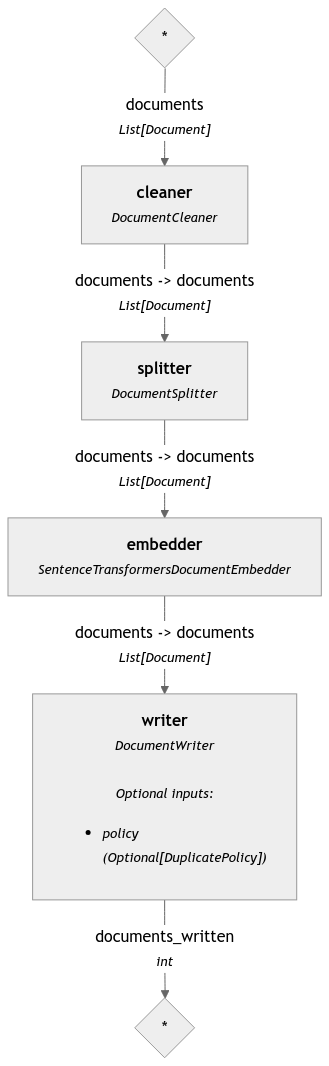

In [12]:
indexing = Pipeline()
indexing.add_component("cleaner", DocumentCleaner())
indexing.add_component("splitter", DocumentSplitter(split_by='sentence', split_length=2))
indexing.add_component("embedder", SentenceTransformersDocumentEmbedder(model=model_emb,
                                                                            device=ComponentDevice.from_str(device),
                                                                            meta_fields_to_embed=["title"]))
indexing.add_component("writer", DocumentWriter(document_store=document_store, policy=DuplicatePolicy.OVERWRITE))

indexing.connect("cleaner", "splitter")
indexing.connect("splitter", "embedder")
indexing.connect("embedder", "writer")

indexing.run({"cleaner":{"documents": raw_docs}})
indexing.show()

Inspecting the Document Store:

In [15]:
num_documents = len(document_store.filter_documents())
print(f"Number of documents in store: {num_documents}")

document_meta = document_store.filter_documents()[0].meta
print("Metadata of document:", document_meta)


Number of documents in store: 1306
Metadata of document: {'title': 'FIFA World Cup', 'url': 'https://en.wikipedia.org/wiki/FIFA_World_Cup', 'source_id': '019091237080c1d52ababf9a11051c2c90933e79c19917e7af322bc15750c48c', 'page_number': 1, 'split_id': 0, 'split_idx_start': 0}


### The RAG Pipeline (Generate + Retrieve Stage)

- In Haystack 2.0, we use the `HuggingFaceLocalGenerator` for managing Open Source LLMs.

- We start with `SmolLM2-1.7B-Instruct`, and later test smaller variants.

- The model is loaded with **4-bit quantization** using `huggingface_pipeline_kwargs` in the Generator.

In [ ]:
generator = HuggingFaceLocalGenerator("HuggingFaceTB/SmolLM2-135M-Instruct",
                                 huggingface_pipeline_kwargs={"device_map":"auto",
                                               "model_kwargs":{"load_in_4bit":True,
                                                "bnb_4bit_use_double_quant":True,
                                                "bnb_4bit_quant_type":"nf4",
                                                "bnb_4bit_compute_dtype":torch.bfloat16}},
                                 generation_kwargs={"max_new_tokens": 350})